In [1]:
import os, glob
from pathlib import Path
from tqdm.notebook import tqdm
tqdm.pandas()

from itertools import accumulate
from collections import Counter

import numpy as np
import pandas as pd

from faster_rcnn import *
#from yolo import load_image_pixels, decode_netout, correct_yolo_boxes, do_nms, get_boxes, draw_boxes
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

from utils import *

import plotly.graph_objects as go

import dash
from dash import dcc
from dash import html

# OKVQA - Investigating Visual data

This notebook examines the OKVQA dataset Visual side. The attributes and building of the dataset follows the configuration used by the widely applied [VQA dataset](https://visualqa.org/download.html). 

## 1) Load data
We start by loading the OKVQA datasets that we analyzed and modified a bit in the `okvqa_test.ipynb` file. Furthermore, we load the image file names!

In [2]:
# path to okvqa dataset (from text-investigation)
filename = 'okvqa_QA.npy'
data_path = Path(os.getcwd())

okvqa = {}
okvqa['full'] = pd.read_pickle(data_path/filename)

In [3]:
# load image filenames
# Load features
data_path = Path.home() / '.cache/torch/mmf/data/datasets/okvqa/defaults/images'

alberts_sisters_computer = True
if alberts_sisters_computer:
    data_path = Path('/Users/Olivia/Desktop/albert/images')

image_names = glob.glob(data_path.as_posix()+'/*.jpg')

In [4]:
# thought: load/open an image, do the computations and then close it again. add the stats to the dataframe

## 2) Images

We will analyze the images by applying an object detection model to each image and then analyzing the item content of images. For simplicity, we use a pretrained Faster-RCNN object detection model with a ResNet50 structure for object detection, as it is similar to how we model the VQA task. The code is taken with inspiration from [here.](https://haochen23.github.io/2020/04/object-detection-faster-rcnn.html#.YksEji0Ykb0)

In [ ]:
# load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# set to evaluation mode
model.eval()

We show an example of the object detection before applying it "blindly" to all images in the OKVQA dataset.

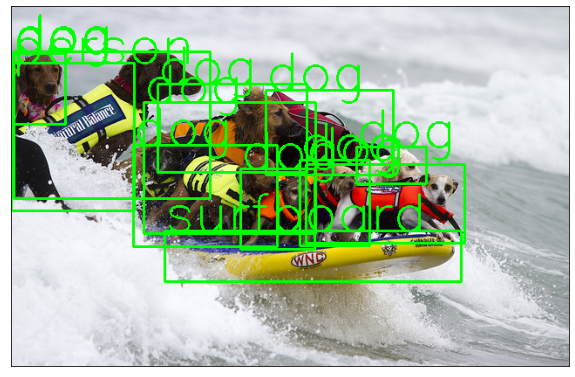

In [59]:
filename = image_names[0]

# show detected objects
detect_object(model, filename, confidence=0.7)#, figsize=(10,15))

Now we apply the object detection model on all images in the OKVQA dataset. This is done with a threshold of 70% certainty of the object.

In [32]:
image_labels = {}
for filename in tqdm(image_names[:5]):
    # predict / detect objects in image
    _, pred_class = get_prediction(model, filename, confidence=0.7)
    
    # save labels
    img_name = filename.split(os.sep)[-1].split(".")[0]
    image_labels[img_name] = pred_class


In [33]:
image_items = [image_labels.get(name, []) for name in tqdm(okvqa['full'].image_name)]
okvqa['full']['image_items'] = image_items

We check whether there are certain images where the object detection model did not find any objects - if so, they are removed from the further analyses. 

In [60]:
# find images where no objects were detected
no_objects = okvqa['full'].image_items.apply(lambda x: x.__len__() == 0)
print(f"Number of QA-pairs without clear objects on the image: {no_objects.sum()}")

# drop images where no objects were detected
okvqa['full'] = okvqa['full'][-no_objects].reset_index().drop('index', axis=1)
okvqa['full'].head()

Number of QA-pairs without clear objects on the image: 0


,image_id,question_id,answer_type,question_type,confidence,question_str,question_tokens,all_answers,answers,image_name,feature_path,annotator_agreement_cos,image_items
0,6229,62295,other,eight,3,If one of the dogs falls off this apparatus wi...,"[if, one, of, the, dogs, falls, off, this, app...","[float, float, float, float, float, float, sho...","[float, float, float, float, float, float, sho...",COCO_train2014_000000006229,COCO_train2014_000000006229.npy,0.974586,"[dog, dog, dog, dog, dog, dog, dog, surfboard,..."
1,2258,22585,other,one,2,What is pulling this airplane?,"[what, is, pulling, this, airplane]","[tug, tug, tug, tug, vehicle, vehicle, pushbac...","[tug, tug, tug, tug, vehicle, vehicle, pushbac...",COCO_train2014_000000002258,COCO_train2014_000000002258.npy,0.983996,"[airplane, truck, person]"
2,1036,10365,other,five,2,What vitamin is associated with the vegetable ...,"[what, vitamin, is, associated, with, the, veg...","[vitamin k, vitamin k, vitamin k, vitamin k, c...","[vitamin k, vitamin k, vitamin k, vitamin k, c...",COCO_train2014_000000001036,COCO_train2014_000000001036.npy,0.968708,"[dining table, knife]"
3,4761,47615,other,three,3,Is this a laptop or desktop?,"[is, this, a, laptop, or, desktop]","[desktop, desktop, desktop, desktop, desktop, ...","[desktop, desktop, desktop, desktop, desktop, ...",COCO_train2014_000000004761,COCO_train2014_000000004761.npy,0.976364,"[chair, keyboard, tv, potted plant, mouse, boo..."
4,4239,42395,other,ten,5,Which season do you find this weather?,"[which, season, do, you, find, this, weather]","[winter, winter, winter, winter, winter, winte...","[winter, winter, winter, winter, winter, winte...",COCO_train2014_000000004239,COCO_train2014_000000004239.npy,NaN,"[person, snowboard]"


In [ ]:
# cocoAPI for real captions

# number of objects
# which objects
# persons?

## Conclusions and considerations:

Through investigations of the data, we get a first intuition of the prerequisites for later explaining VQA model performance. Thus, through this investigation multiple things became evident to us:

Images:
> -

These findings can help us determine how to construct evaluation protocols when evaluating our VQA systems. From these we suggest the following leveling of question (in terms of abstractness):

1. ...
2. negation
3. subject-pronoun replacement
4. numerical sense / intuition
5. multi-hop reasoning
6. 
7. art? or subjectively associated questions/pictures